# Only Fine Structure (Movre Pischler) Reorganized

## Setup

In [1]:
import numpy as np
import sympy as sp
sp.init_printing(use_latex=True)
from sympy.physics.quantum import Bra, Ket, qapply, Dagger as Dag
from sympy.physics.quantum.cg import CG
np.set_printoptions(precision=3,suppress=True,linewidth=100000, edgeitems=10000)
from sympy.physics.wigner import wigner_9j
from sympy.physics.secondquant import KroneckerDelta
import math
import time
import scipy.linalg
import IPython.display
from IPython.display import Latex
import matplotlib.pyplot as plt
import MarksConstants as mc
import Miscellaneous as misc

from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from IPython.display import Latex

import matplotlib as mpl
import matplotlib.style
matplotlib.style.use('default')
%matplotlib inline
from copy import copy
from importlib import reload

import MoleculeCalculation as mol

In [2]:
reload(mol)

<module 'MoleculeCalculation' from 'C:\\Users\\Mark-Brown\\Code\\Molecules_Code_New\\MoleculeCalculation.py'>

# Calculation

In [3]:
lsiBasis, jiBasis, fBasis, lsiBasis2Atom, jiBasis2Atom, fBasis2Atom = mol.createAtomicBases([0,1], [1/2], [0])

In [4]:
E_HFS_5S12_F1F2 = (mc.Rb87_Ground_ToF2-mc.Rb87_Ground_ToF1)/2
E_HFS_5P12_F1F2 = (mc.Rb87_5P12_ToF2-mc.Rb87_5P12_ToF1)/2
E_FS_5P12_5P32 = mc.h*(mc.Rb87_D2LineFrequency-mc.Rb87_D1LineFrequency)# / mc.h

transFreq = 2*np.pi*(mc.Rb87_D2LineFrequency+mc.Rb87_D1LineFrequency)/2
lifetime = (mc.Rb87_D1_Lifetime+mc.Rb87_D2_Lifetime)/2
C_3_val_alt = 3*mc.hbar*mc.c**3/(4*lifetime*transFreq**3)# * 1e27 / mc.h

C_3_val = mc.Rb87_C3
print(E_FS_5P12_5P32, C_3_val)
print("From first principles one can calculate C3 to be: ", C_3_val_alt, "but this differs from the literature value which is: ", C_3_val)

4.7197635548748796e-21 5.94492796981645e-48
From first principles one can calculate C3 to be:  5.774794407751793e-48 but this differs from the literature value which is:  5.94492796981645e-48


In [5]:
lifetime = (mc.Rb87_D1_Lifetime+mc.Rb87_D2_Lifetime)/2
transFreq = 2*np.pi*(mc.Rb87_D2LineFrequency+mc.Rb87_D1LineFrequency)/2
DeltaVal = mc.h*(mc.Rb87_D2LineFrequency-mc.Rb87_D1LineFrequency)# / mc.h
C_3_val = 3*mc.hbar*mc.c**3/(4*lifetime*transFreq**3)# * 1e27 / mc.h
C_3_val = mc.Rb87_C3
print(DeltaVal, C_3_val)

4.7197635548748796e-21 5.94492796981645e-48


In [30]:
fsOperator_unitless = mol.create_H_FS(jiBasis2Atom)
lsToJOp2 = mol.create_lsi2ToJi2_Op(lsiBasis2Atom,jiBasis2Atom)
fsOperator = fsOperator_unitless * 2 * DeltaVal / 3

## Create Symmetrized Fine Structure Hamiltonians

In [7]:
expandedBOBasis = mol.addFsRelevantStates(mol.boStates)

In [8]:
for state in expandedBOBasis: # to work with hfs code
    state.update({'L':1,'|Iota|':0,'I':0,'i_a':0,'i_b':0,'|Phi|':state['|Omega|'], 'kappa_HFS':state['kappa_FS']})

In [9]:
totalSpatialParityIncluded = ['a','b']
symmetrizedBases = {}
for Omega in [0,1,2]:
    for state in expandedBOBasis:
        if math.isclose(state['|Omega|'], Omega):
            if Omega == 0:
                parityString = '+' if state['kappa_FS'] == 1 else '-'
            else:
                parityString = ''
            symmetryLabel = str(Omega) + parityString + state['I_BO']
            if symmetryLabel not in symmetrizedBases:
                symmetrizedBases[symmetryLabel] = []
            symmetrizedBases[symmetryLabel].append(state)

### Create $\phi = 0$ Bases

I need to sort the states in the complete basis "caseASymHfs" by their symmetry label so that I can calculate the different symmetries separately and label them appropriately at the end.

In [14]:
lsiBasis, jiBasis, fBasis, lsiBasis2Atom, jiBasis2Atom, fBasis2Atom = mol.createAtomicBases([0,1], [1/2], [0])
lsiToJi_Op = mol.create_lsiToJi_Op(lsiBasis,jiBasis)
jiToF_Op = mol.create_jiToF_Op(jiBasis, fBasis)

#lsi2ToJi2_Op = mol.create_lsi2ToJi2_Op(lsiBasis2Atom,jiBasis2Atom)
#ji2ToF2_Op = mol.create_(jiBasis, fBasis)

caseAMostlySymHfs = mol.createCaseABasis_MostlySym([1], [0,1], [0], I_BOvals=['g', 'u'])
caseASymHfs = mol.createCaseABasis_Sym([1], [0,1], [0], I_BOvals=['g','u'])

In [15]:
expandedBOBasis = mol.addFsRelevantStates(mol.boStates)
caseASymHfs = mol.addHfsRelevantStates(expandedBOBasis, i_val=0)

In [16]:
phi=0
totalSpatialParityIncluded = ['a','b']
symmetrizedBases = {}
for phi in np.arange(6):
    for totalSpatialParity in totalSpatialParityIncluded:
        totalSpatialParityVal = 1 if totalSpatialParity == 'a' else -1
        for state in caseASymHfs:
            I_BOval = mol.g if state['I_BO'] == 'g' else mol.u
            if math.isclose(abs(state['|Phi|']),phi):
            #if math.isclose(abs(state['Phi']),phi):
                if (-1)**(state['I']+I_BOval) == totalSpatialParityVal:
                    kappa_HFS_ParityStr = '1' if state['kappa_HFS'] == 1 else '2'
                    symmetryLabel = str(phi) + totalSpatialParity + kappa_HFS_ParityStr
                    if symmetryLabel not in symmetrizedBases:
                        symmetrizedBases[symmetryLabel] = []
                    symmetrizedBases[symmetryLabel].append(state)

### Create $\phi = 1$ through $5$ Bases

In [18]:
phiIncluded=np.arange(1,6)
totalSpatialParityIncluded = ['a','b']
mostlySymmetrizedBases = {}
for phi in phiIncluded:
    for totalSpatialParity in totalSpatialParityIncluded:
        totalSpatialParityVal = 1 if totalSpatialParity == 'a' else -1
        for state in caseAMostlySymHfs:
            I_BOval = mol.g if state['I_BO'] == 'g' else mol.u
            if math.isclose(abs(state['Phi']),phi):
                if (-1)**(state['I']+I_BOval) == totalSpatialParityVal:
                    label = str(phi) + totalSpatialParity
                    if label not in mostlySymmetrizedBases:
                        mostlySymmetrizedBases[label] = []
                    mostlySymmetrizedBases[label].append(state)

In [19]:
mostlySymmetrizedBases.keys()

dict_keys(['1a', '1b', '2a', '2b'])

In [31]:
reload(mol)
caseAMostlySymHfs = mol.createCaseABasis_MostlySym([1],[0,1], [0], I_BOvals=['g', 'u'])
H_fs_phi, H_hfs_phi = {}, {}
#for label, base in {**symmetrizedBases, **mostlySymmetrizedBases}.items():
for label, base in symmetrizedBases.items():
    print('Working on states of symmetry ' + label +". " + str(len(base)) + " states")
    caseAToLsi = mol.genCaseAToLsiTransform(base, lsiBasis, caseAMostlySymHfs, basisChange=None).T
    #caseAToLsi = mol.genCaseAToLsiTransform2(base, lsiBasis2Atom, caseAMostlySymHfs).T
    caseAToJi =  lsToJOp2 @ caseAToLsi
    H_fs_phi[label] = caseAToJi.T @ fsOperator @ caseAToJi + np.identity(len(base))*(-1/2* 2 * E_FS_5P12_5P32 / 3)

Working on states of symmetry 0a1. 2 states
[1] [1]                   
[5, 4] [1, 1]             
Working on states of symmetry 0a2. 2 states
[0] [1]                   
[5, 4] [1, -1]            
Working on states of symmetry 0b1. 2 states
[3] [1]                   
[7, 6] [1, 1]             
Working on states of symmetry 0b2. 2 states
[2] [1]                   
[7, 6] [1, -1]            
Working on states of symmetry 1a2. 2 states
[17, 16] [1, 1]           
[11, 9] [1, 1]            
Working on states of symmetry 1a1. 1 states
[10, 8] [1, 1]            
Working on states of symmetry 1b2. 2 states
[19, 18] [1, 1]           
[15, 13] [1, 1]           
Working on states of symmetry 1b1. 1 states
[14, 12] [1, 1]           
Working on states of symmetry 2a1. 1 states
[21, 20] [1, 1]           
Working on states of symmetry 2b1. 1 states
[23, 22] [1, 1]           


## Results

In [32]:
mpl.rcParams['figure.dpi']=300

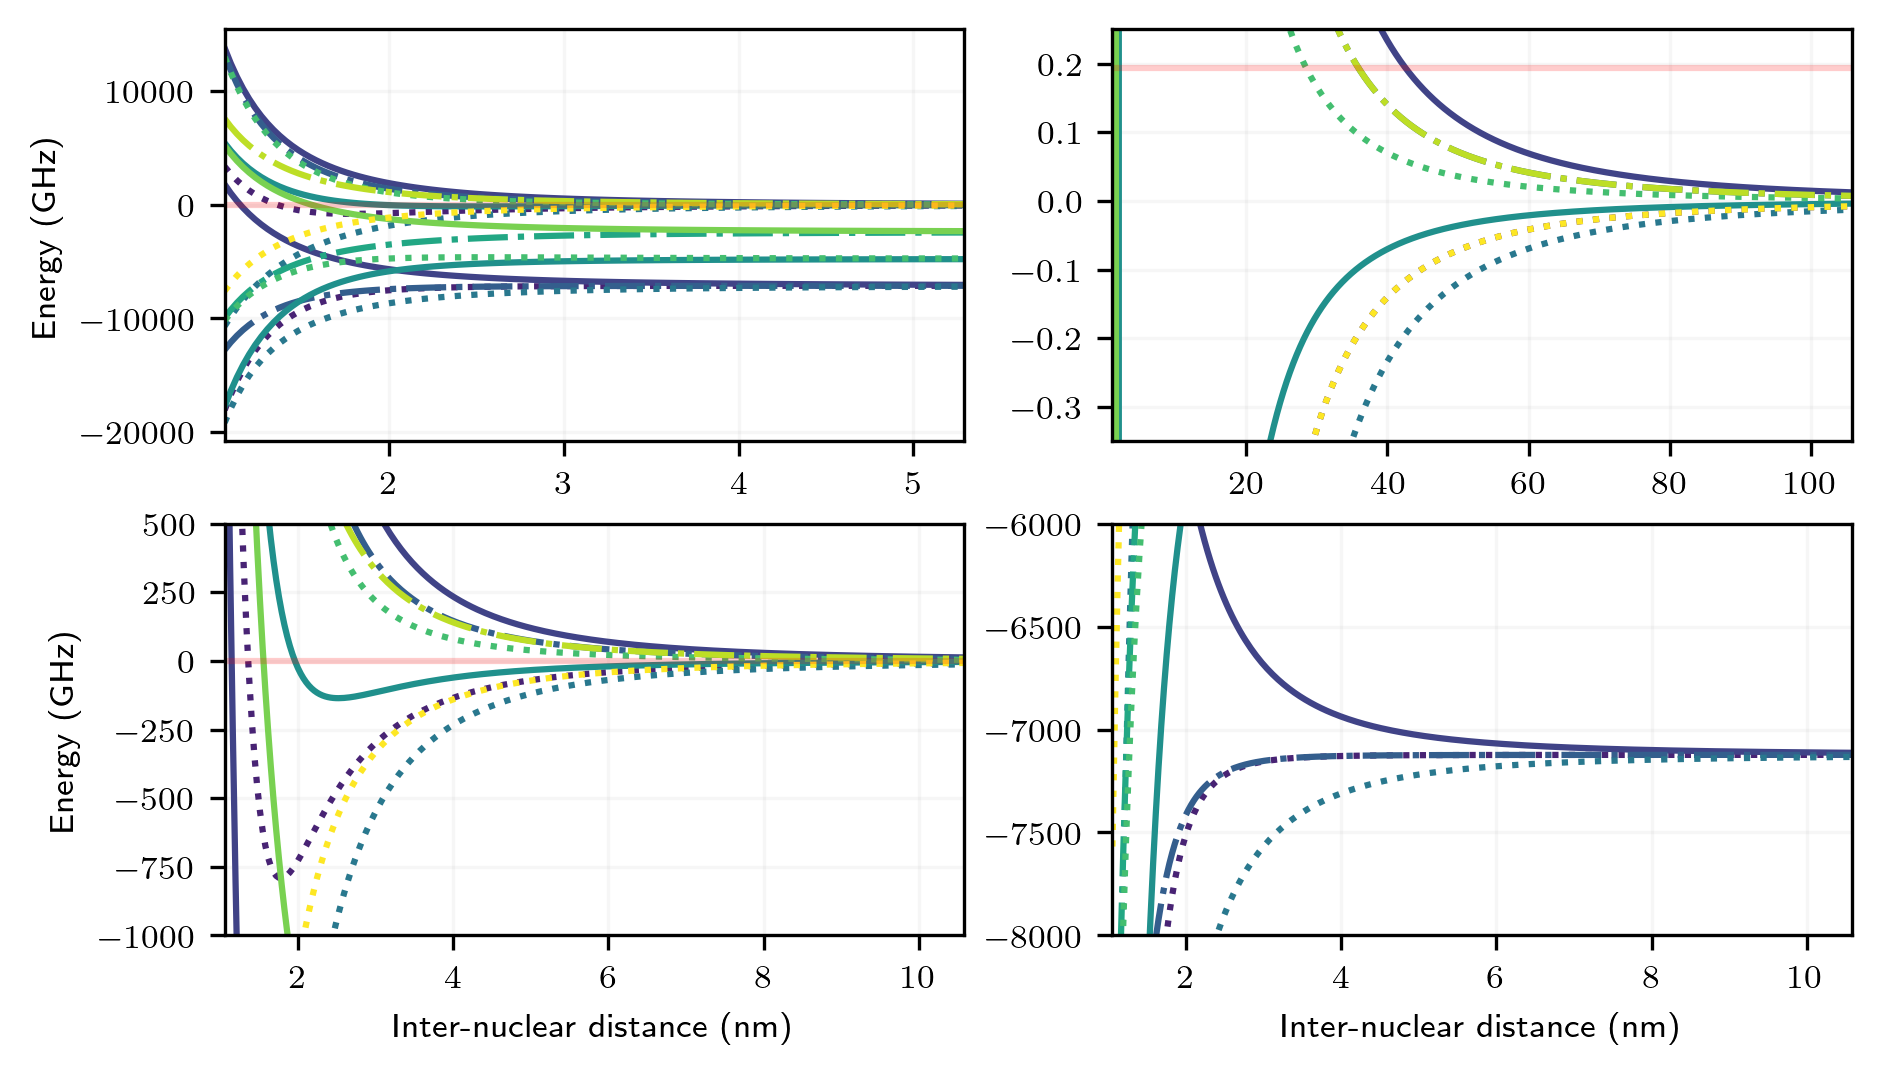

In [33]:
fig, axs = plt.subplots(2,2,figsize=(7,4))
Rvals = np.linspace( 20 * mc.a0, 2000 * mc.a0, 3000 )
linestyles=[':','-','-.',':','-','-.',':','-','-.',':','-','-.']
allBases = {**symmetrizedBases }
colors, _ = misc.getColors(len(allBases), cmStr='viridis')
data = {}
for basisNum, (label, basis) in enumerate(allBases.items()):
    #for matrixnum, (name, potentialMatrix, c_, boStates) in enumerate(zip(names, potentialList, colors, BohrOppenheimerStates)):
    for rv in Rvals:
        rMatrix = mol.get_H_BO(C_3_val, rv, basis).astype(float) + H_fs_phi[label]
        #rMatrix = mol.get_H_BO(C_3_val, rv, basis).astype(float)
        #rMatrix = createBOMatrix(C_3_val, rv, *boStates).astype(float) + potentialMatrix * 2 * DeltaVal / 3
        if label not in data:
            data[label]=[]
        data[label].append(sorted(np.linalg.eigvals(rMatrix)))
        
for ax in axs.flatten():
    if False:
        ax.axhline(-0.0729113, alpha=0.2,color='r')
        ax.axhline(-0.2298518, alpha=0.2,color='r')
        ax.axhline(-0.30207388, alpha=0.2,color='r')
        ax.axhline(-DeltaVal* 1e-9 / mc.h+0.306246, alpha=0.2,color='r')
        ax.axhline(-DeltaVal* 1e-9 / mc.h-0.510410, alpha=0.2,color='r')
    
    for num, label in enumerate(data.keys()):
        mdata = data[label]
        linestyle = linestyles[num]
        c_ = colors[num]
        if len(np.array(mdata).shape) == 2 or len(np.array(mdata).shape) == 3:
            for lineNum, lineData in enumerate(misc.transpose(mdata)):
                ax.plot(Rvals*1e9, np.array(lineData) * 1e-9 / mc.h, 
                        label=label if lineNum == 0 else None, color=c_, linestyle=linestyle)
        else:
            ax.plot(Rvals*1e9, np.array(mdata) * 1e-9 / mc.h, 
                    label=name, color=c_, linestyle=linestyle)
    
    #ax.set_xlabel('Inter-nuclear distance (nm)')
    #ax.set_ylabel('Energy (GHz)')
    ax.grid(alpha=0.1)
    ax.axhline(0.1937408, alpha=0.2,color='r', label='F States')

axs[1,0].set_xlabel('Inter-nuclear distance (nm)')
axs[1,1].set_xlabel('Inter-nuclear distance (nm)')
axs[0,0].set_ylabel('Energy (GHz)')
axs[1,0].set_ylabel('Energy (GHz)')
axs[0,0].set_xlim(min(Rvals)*1e9,max(Rvals)*1e9/20)
#axs[0,0].legend(ncol=5,fontsize=8)
#axs[1,0].set_title('Zoom $5P_{3/2}$')
axs[1,0].set_xlim(min(Rvals)*1e9,max(Rvals)*1e9/10)
axs[1,0].set_ylim(-1000, 500)
#axs[0,1].set_title('Super-Zoom $5P_{3/2}""$')
axs[0,1].set_xlim(min(Rvals)*1e9,max(Rvals)*1e9)
axs[0,1].set_ylim(-0.35, 0.25)
#axs[1,1].set_title('Zoom $5P_{1/2}$')
axs[1,1].set_xlim(min(Rvals)*1e9,max(Rvals)*1e9/10)
axs[1,1].set_ylim(-8000, -6000);
#plt.savefig('Movre-Pischler.png', dpi=200)www

### paper figure

In [34]:
mpl.rcParams['font.size'] = 8
mpl.rcParams['text.usetex']=True

C:\Users\MARK-B~1\AppData\Local\Temp/ipykernel_1124/3722443988.py:56: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  fig.text(0.03, 0.5, "Energy (GHz)", rotation=90, verticalAlignment='center')
C:\Users\MARK-B~1\AppData\Local\Temp/ipykernel_1124/3722443988.py:57: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  fig.text(0.5, 0.03, "Inter-Nuclear Distance (nm)", horizontalAlignment='center')


Saving Fig...
Rendering Fig...


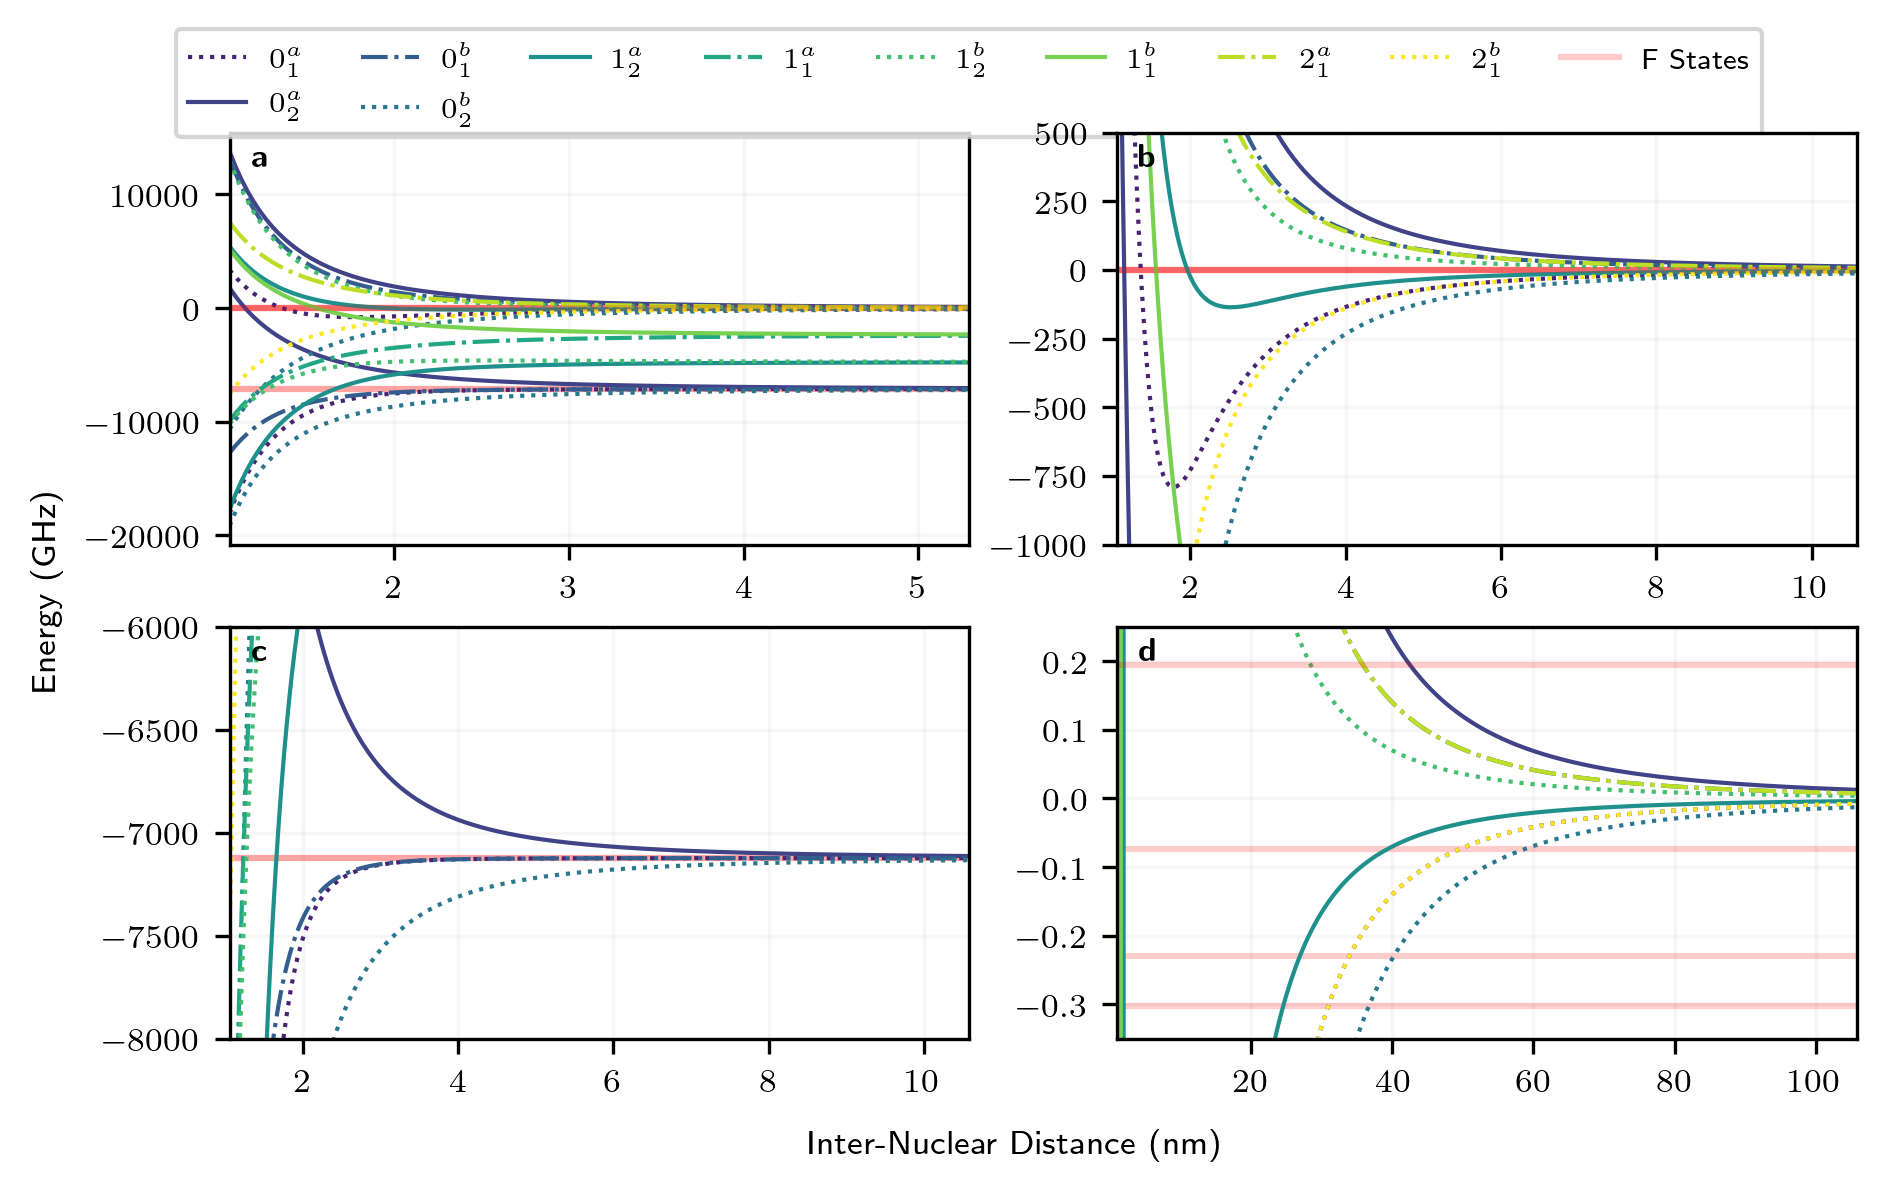

In [35]:
fig, axs = plt.subplots(2,2,figsize=(7,4))
Rvals = np.linspace( 20 * mc.a0, 2000 * mc.a0, 3000 )
linestyles=[':','-','-.',':','-','-.',':','-','-.',':','-','-.']
allBases = {**symmetrizedBases }
colors, _ = misc.getColors(len(allBases), cmStr='viridis')
data = {}

for basisNum, (label, basis) in enumerate(allBases.items()):
    #for matrixnum, (name, potentialMatrix, c_, boStates) in enumerate(zip(names, potentialList, colors, BohrOppenheimerStates)):
    for rv in Rvals:
        rMatrix = mol.get_H_BO(C_3_val, rv, basis).astype(float) + H_fs_phi[label]
        #rMatrix = mol.get_H_BO(C_3_val, rv, basis).astype(float)
        #rMatrix = mol.get_H_BO(C_3_val, rv, basis).astype(float) + potentialMatrix * 2 * DeltaVal / 3
        if label not in data:
            data[label]=[]
        data[label].append(sorted(np.linalg.eigvals(rMatrix)))
        
for axnum, ax in enumerate(axs.flatten()):
    if True:
        ax.axhline(-0.0729113, alpha=0.2,color='r')
        ax.axhline(-0.2298518, alpha=0.2,color='r')
        ax.axhline(-0.30207388, alpha=0.2,color='r')
        ax.axhline(-DeltaVal* 1e-9 / mc.h+0.306246, alpha=0.2,color='r')
        ax.axhline(-DeltaVal* 1e-9 / mc.h-0.510410, alpha=0.2,color='r')
    
    for num, label in enumerate(data.keys()):
        mdata = data[label]
        linestyle = linestyles[num]
        c_ = colors[num]
        if len(label)==2:
            legLabel='$'+label[0]+'_'+label[1]+'$'
        if len(label)==3:
            legLabel='$'+label[0]+'^'+label[1]+'_'+label[2]+'$'
        if len(np.array(mdata).shape) == 2 or len(np.array(mdata).shape) == 3:
            for lineNum, lineData in enumerate(misc.transpose(mdata)):
                ax.plot(Rvals*1e9, np.array(lineData) * 1e-9 / mc.h, 
                        label=legLabel if lineNum == 0 else None, color=c_, linestyle=linestyle, lw=1)
        else:
            ax.plot(Rvals*1e9, np.array(mdata) * 1e-9 / mc.h, 
                    label=name, color=c_, linestyle=linestyle)
    ax.grid(alpha=0.1)
    ax.axhline(0.1937408, alpha=0.2,color='r', label='F States')
    ax.text(0.03, 0.92,r'\textbf{'+['a','b','c','d'][axnum]+r'}', transform=ax.transAxes)

axs[0,0].set_xlim(min(Rvals)*1e9,max(Rvals)*1e9/20)
axs[0,0].legend(ncol=9, fontsize=7, bbox_to_anchor=[0.5,0.87,1,0.5], loc='center')
axs[0,1].set_xlim(min(Rvals)*1e9,max(Rvals)*1e9/10)
axs[0,1].set_ylim(-1000, 500)
axs[1,1].set_xlim(min(Rvals)*1e9,max(Rvals)*1e9)
axs[1,1].set_ylim(-0.35, 0.25)
axs[1,0].set_xlim(min(Rvals)*1e9,max(Rvals)*1e9/10)
axs[1,0].set_ylim(-8000, -6000);
#axs[0,0].axhline(-8000, linestyle=':',color='#AAAAAA')
#axs[0,0].axhline(-6000)

fig.text(0.03, 0.5, "Energy (GHz)", rotation=90, verticalAlignment='center')
fig.text(0.5, 0.03, "Inter-Nuclear Distance (nm)", horizontalAlignment='center')
print('Saving Fig...')
#plt.savefig('Fine_Structure_Only.png', dpi=200)
print('Rendering Fig...')